<h1 style="text-align: center;">Applied Data Science Capstone</h1>
----------
<h2 style="text-align: center;">Determining the best locations to open a new Souvlaki shop in: Athens - Greece</h2>
<h3 style="text-align: center;">Kostas Smonos</h3>
<h3 style="text-align: center;">November 29, 2020</h3>

* ## 1.Scrape Wikipedia and prepare data

In [169]:
#importing needed libraries
import requests
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
#!pip install lxml              #uncomment to install lxml parser
#!pip install beautifulsoup4    #uncomment to install bs
from bs4 import BeautifulSoup

### Grab Athens metro stations table

In [419]:
url = 'https://en.wikipedia.org/wiki/List_of_Athens_Metro_stations'
s = requests.Session()
response = s.get(url, timeout = 10)
soup = BeautifulSoup(response.content, "html.parser")

# to fix the content idents etc and make it readable
pretty_soup = soup.prettify()
# finding the correct table and its headers
table = soup.find('table', {'class' : 'wikitable sortable'})

In [237]:
def dms2dd(tup1):        #Helper function to convert DMS to DD format
    try:
        dd = float(tup1[0:2]) + float(tup1[3:5])/60 + float(tup1[6:8])/(60*60);
        if (tup1[9].upper() == "S") or (tup1[9].upper() == "W"):
            return -dd;
        return dd;
    except:
        print("could not parse ", str(tup1), " Please add manually")

def getLocationFromWiki(url):
    s = requests.Session()
    response = s.get(url, timeout = 10)
    soup = BeautifulSoup(response.content, "html.parser")
    pretty_soup = soup.prettify()
    try:
        lat = soup.find('span', {'class' : 'latitude'}).get_text()
        lng = soup.find('span', {'class' : 'longitude'}).get_text()
        lat = dms2dd(lat)    #Wiki returns location data in DMS format. Convert to DD
        lng = dms2dd(lng)
        return [lat, lng]
    except:
        return [np.nan, np.nan]

### Extracting column names, rows and station links from table

In [238]:
rows = table.find_all("tr")
headers = [th.text.rstrip() for th in rows[0].find_all("th")]
headers.append('Link')

# grabbing rows
table_rows = []
links = []
for row in rows[1:]:
    data = [d.text.rstrip() for d in row.find_all("td")]
    for b in row.find_all('a', href=True):
        if data[1] in b:
            link = 'https://en.wikipedia.org' + b['href']
            break
    data.append(link)
    table_rows.append(data)

### Creating a Pandas DataFrame with the extracted data

In [239]:
df = pd.DataFrame(data = table_rows, columns = headers).drop(['Line(s)', 'Station nameGreek', 'Transfers', 'Opening date', 'Platform location'], axis = 1)
df = df.rename(columns = {'Station nameEnglish' : 'Station'})
df

,Station,Municipality,Link
0,Agia Marina,Agia Varvara,https://en.wikipedia.org/wiki/Agia_Marina_metr...
1,Agia Paraskevi,Chalandri,https://en.wikipedia.org/wiki/Agia_Paraskevi_m...
2,Agia Varvara,Agia Varvara,https://en.wikipedia.org/wiki/Agia_Varvara_met...
3,Agios Antonios,Peristeri,https://en.wikipedia.org/wiki/Agios_Antonios_m...
4,Agios Dimitrios-Alexandros Panagoulis,Agios Dimitrios,https://en.wikipedia.org/wiki/Agios_Dimitrios_...
...,...,...,...
59,Syngrou Fix,Athens,https://en.wikipedia.org/wiki/Syngrou_Fix_station
60,Syntagma,Athens,https://en.wikipedia.org/wiki/Syntagma_metro_s...
61,Tavros – Eleftherios Venizelos,Kallithea,https://en.wikipedia.org/wiki/Tavros_%E2%80%93...
62,Thissio,Athens,https://en.wikipedia.org/wiki/Thiseio_metro_st...


### Grab and convert location data for each station to Lat Lon

In [240]:
locations = []
for link in df.Link:
    loc = getLocationFromWiki(link)
    #print(loc)
    if loc == None:
        locations.append([np.nan, np.nan])
    else:
        locations.append(loc)
print("Location Data Retrieved")

could not parse  38°4′24″N  Please add manually
Location Data Retrieved


In [241]:
df_loc = pd.DataFrame(locations)
df["Latitude"] = df_loc[0]
df["Longitude"] = df_loc[1]
df.drop('Link', axis = 1, inplace = True)

In [242]:
# Fixing missing values from wikipedia
df = df.set_index('Station')
df.at['Kifissia', 'Latitude'] = 38.073333
df.at['Nikaia', 'Latitude'] =  37.965791
df.at['Nikaia', 'Longitude'] = 23.647391
df.at['Korydallos', 'Latitude'] = 37.9767921
df.at['Korydallos', 'Longitude'] = 23.6509329

In [243]:
df.isnull().values.any()    #Check for any remaining missing values

False

In [397]:
#csv_out = df.reset_index()
#csv_out.to_csv("Metro_Stations_Athens_Locations.csv")      Made a CSV for any future use on the data

In [246]:
#!pip install geocoder      #uncomment to install Geocoder package
#!pip install geopy
from geopy.geocoders import Nominatim
import geocoder
import folium

     |████████████████████████████████| 112kB 4.6MB/s eta 0:00:01


### Map of all subway stations in Athens
Using data i scraped off of wikipedia and converted using my functions

In [393]:
#Making map of all subway stations
address = 'Athens, Attiki'
geolocator = Nominatim(user_agent = 'foursquare_agent')
location = geolocator.geocode(address)
mymap = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)
for lat, lon, lbl in zip(df.Latitude, df.Longitude, df.index.values):
    label = folium.Popup(lbl, parse_html=True)
    folium.CircleMarker([lat,lon], radius = 7, color = 'blue', popup = label, fill = True, fill_color = 'cyan', fill_opacity = 0.5).add_to(mymap)
mymap

-------------------------
* ## 2.Grab Foursquare venues around each station

In [394]:
CLIENT_ID = 'REMOVED' # your Foursquare ID
CLIENT_SECRET = 'REMOVED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [254]:
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [255]:
nearby_venues = getNearbyVenues(df.index.values, df['Latitude'], df['Longitude'])

Agia Marina
Agia Paraskevi
Agia Varvara
Agios Antonios
Agios Dimitrios-Alexandros Panagoulis
Agios Eleftherios
Agios Ioannis
Agios Nikolaos
Airport
Akropoli
Alimos
Ambelokipi
Ano Patisia
Anthoupoli
Argyroupoli
Attiki
Chalandri
Dafni
Doukissis Plakentias
Egaleo
Irini
Eleonas
Elliniko
Ethniki Amyna
Evangelismos
Faliro
Holargos
Ilioupoli-Grigoris Lambrakis
Iraklio
Kallithea
KAT
Katehaki
Kato Patisia
Kerameikos
Kifissia
Koropi
Korydallos
Larissa Station
Marousi
Megaro Mousikis
Metaxourghio
Monastiraki
Moschato
Nea Ionia
Neos Kosmos
Nerantziotissa
Nikaia
Nomismatokopio
Omonia
Paiania-Kantza
Pallini
Panepistimio
Panormou
Pefkakia
Perissos
Peristeri
Petralona
Piraeus
Sepolia
Syngrou Fix
Syntagma
Tavros – Eleftherios Venizelos
Thissio
Victoria


In [257]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agia Marina,37.996944,23.667778,Il Toto,37.996570,23.669360,Coffee Shop
1,Agia Marina,37.996944,23.667778,McDonald's,37.998664,23.665473,Fast Food Restaurant
2,Agia Marina,37.996944,23.667778,Lidl,37.996165,23.669105,Supermarket
3,Agia Marina,37.996944,23.667778,Σκλαβενίτης,37.998139,23.665620,Supermarket
4,Agia Marina,37.996944,23.667778,Το Νησί,37.995125,23.671532,Seafood Restaurant


In [258]:
print('There are {} unique categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 249 unique categories.


In [421]:
nearby_venues.shape

(2295, 7)

<AxesSubplot:title={'center':'Number of Venues within 400 meters of each subway station'}, xlabel='Neighborhood'>

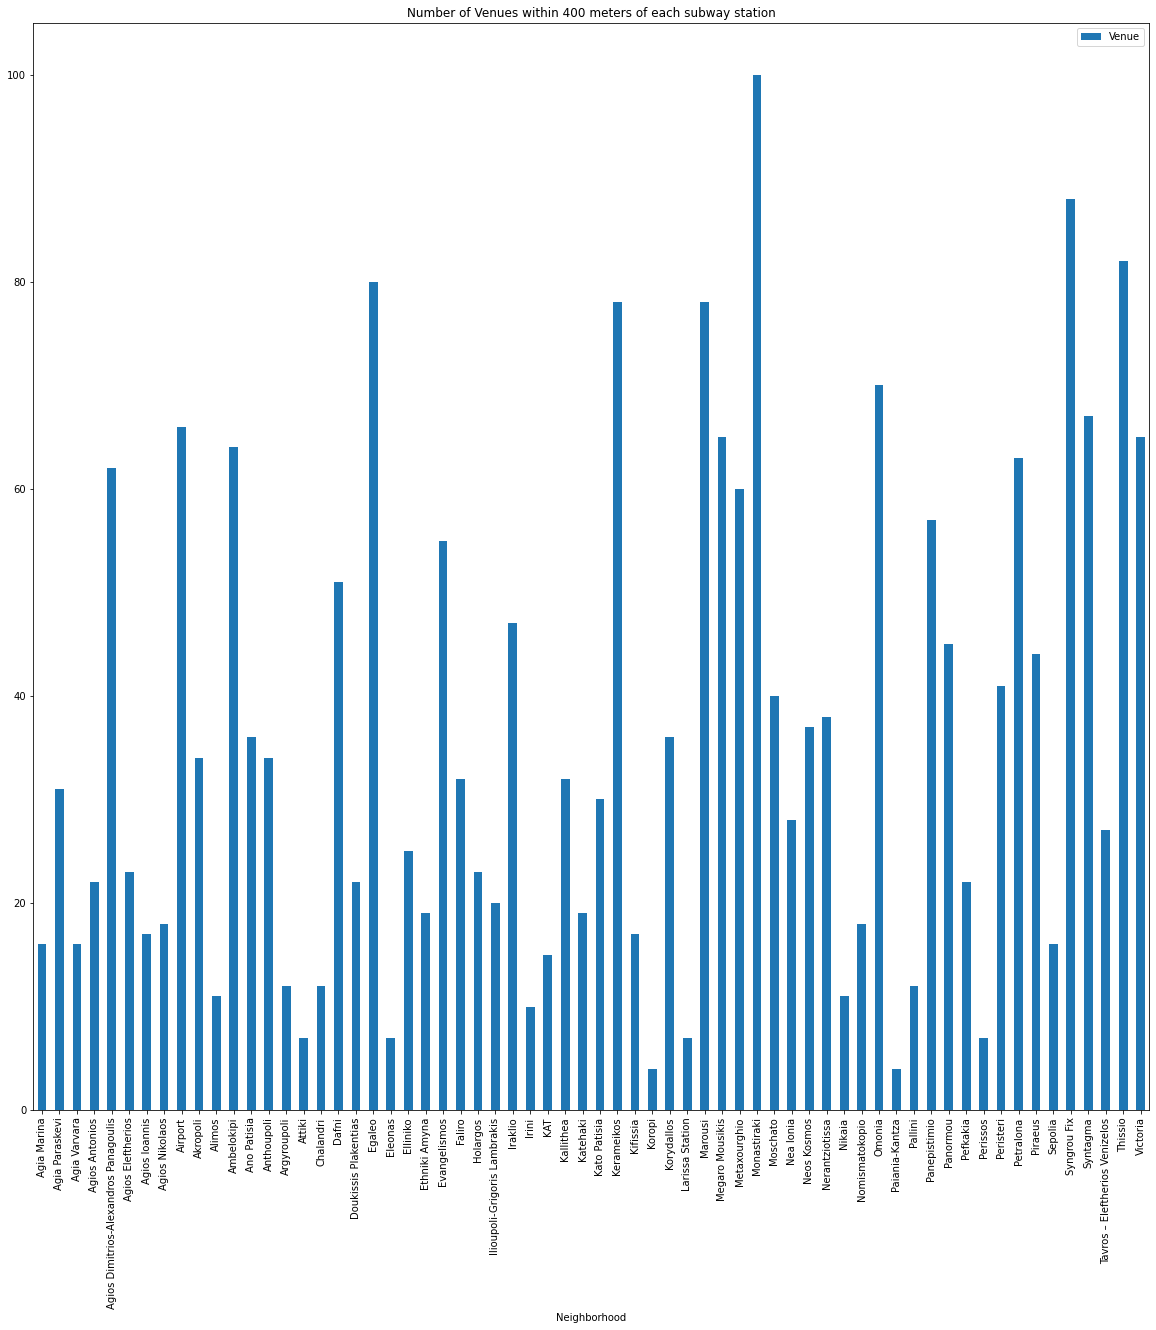

In [408]:
num_venues = nearby_venues
num_venues = num_venues.groupby('Neighborhood').count()
num_venues  = num_venues[['Venue']]
num_venues.rename(columns = {'Venue' : 'Venues in Range'})
num_venues.plot(kind='bar', figsize=(20,20), title="Number of Venues within 400 meters of each subway station")

In [417]:
souvlaki_shops = nearby_venues[nearby_venues['Venue Category'].str.contains('Souvlaki')]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'Number of Souvlaki Shops within 400 meters of each subway station'}, xlabel='Neighborhood'>

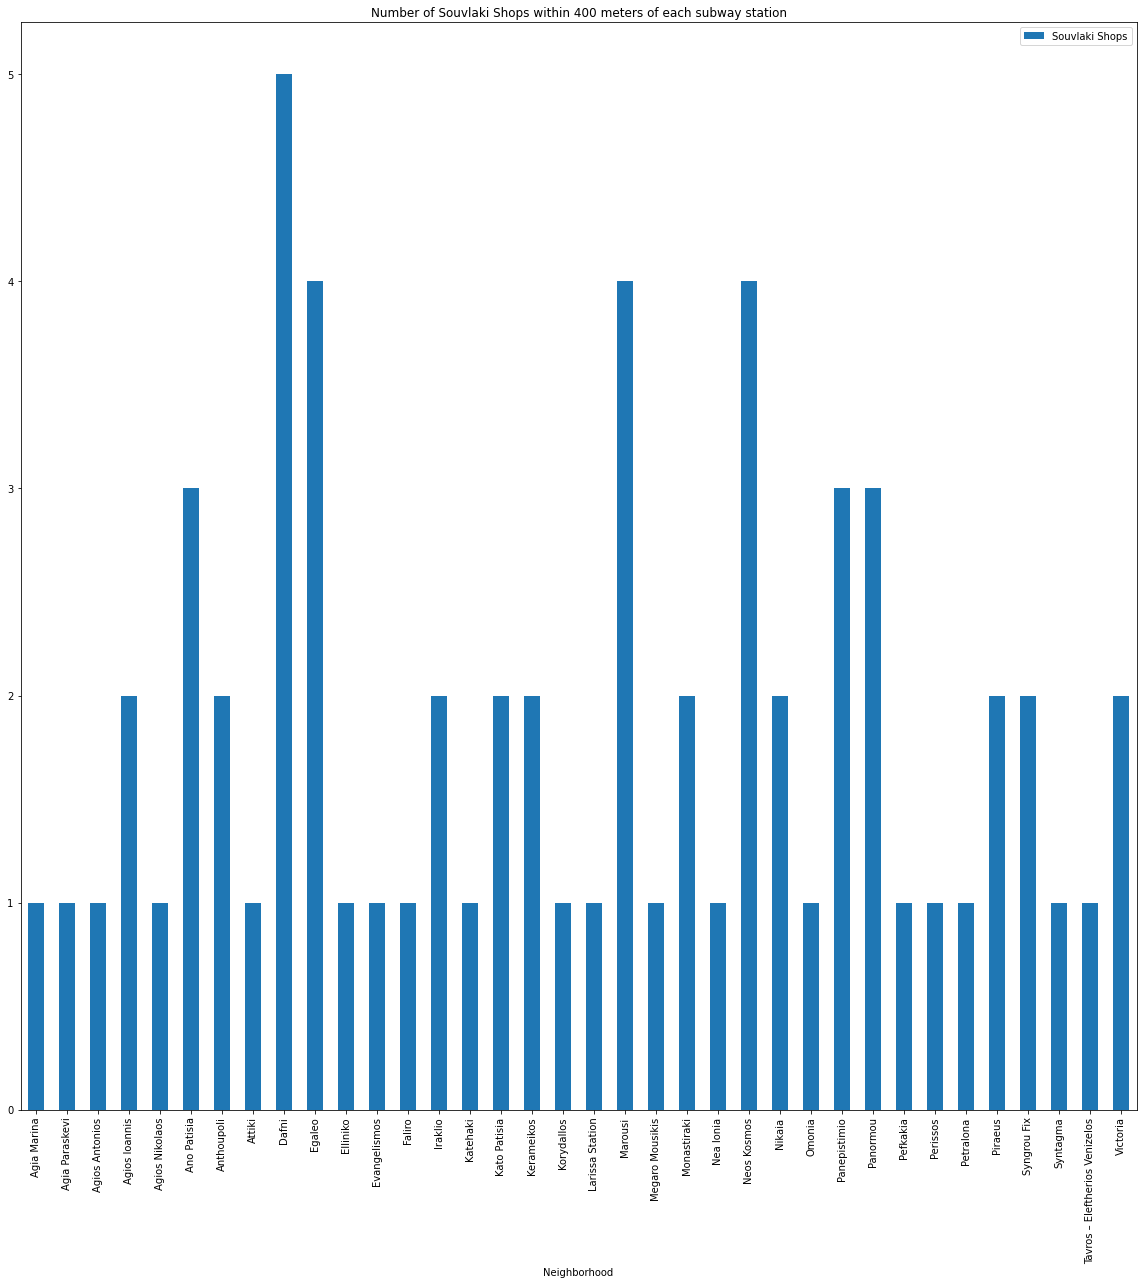

In [418]:
# Sum the amount of souvlaki shops in each area
souvlaki_shops['Venue Category'] = 1
sum_shops = souvlaki_shops.groupby('Neighborhood').sum()
sum_shops.rename(columns = {'Venue Category' : 'Souvlaki Shops'}, inplace=True)
souvlaki_shops = sum_shops[['Souvlaki Shops']]
souvlaki_shops.plot(kind='bar', figsize=(20,20), title="Number of Souvlaki Shops within 400 meters of each subway station")

### We found the number of Souvlaki Shops within 400 meters of each station.
Now we will need to find the sum of venues in general, we want to look for a place that has enough venues (larger than 45) close to the subway as that will indicate a good amount of people walking in the area.

In [423]:
nearby_venues.groupby('Neighborhood').count()
stations_with_many_venues = nearby_venues.groupby('Neighborhood').count()
stations_with_many_venues = stations_with_many_venues[stations_with_many_venues['Venue'] > 45]
stations_with_many_venues.index.values    #These are the subway stations with more than 45 venues close to them
x = pd.DataFrame(souvlaki_shops, index=stations_with_many_venues.index.values).dropna()
x

,Souvlaki Shops
Dafni,5.0
Egaleo,4.0
Evangelismos,1.0
Iraklio,2.0
Kerameikos,2.0
Marousi,4.0
Megaro Mousikis,1.0
Monastiraki,2.0
Omonia,1.0
Panepistimio,3.0


* ## 3.Cluster data using the stations with at least one Souvlaki Shop in range, and more than 45 venues in range of any type
I decided to keep only the ones that had souvlaki shops as that is a safe indicator that a need for such a service in the area exists

In [341]:
from sklearn.cluster import KMeans

In [434]:
filter_df  = df[df.index.isin(x.index.values)]
filter_df['Souvlaki Shops'] = x['Souvlaki Shops']
#filter_df['Venue Number'] = stations_with_many_venues['Venue']
filter_df

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Municipality,Latitude,Longitude,Souvlaki Shops
Station,,,,
Dafni,Dafni,37.950000,23.738333,5.0
Egaleo,Aigaleo,37.991111,23.681667,4.0
Evangelismos,Athens,37.976389,23.746944,1.0
Iraklio,Irakleio,38.046111,23.766111,2.0
Kerameikos,Athens,37.978333,23.711389,2.0
Marousi,Marousi,38.056111,23.804722,4.0
Megaro Mousikis,Athens,37.978611,23.752500,1.0
Monastiraki,Athens,37.976111,23.725556,2.0
Omonia,Athens,37.984167,23.728333,1.0


In [435]:
# set number of clusters
kclusters = 3
df_clustering = filter_df[['Souvlaki Shops']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 1, 1, 2, 0, 1, 0, 1], dtype=int32)

In [439]:
# add clustering labels
#df_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged = df_clustering.drop('Souvlaki Shops', axis = 1)
#df_merged = df_merged.drop('Venue Number', axis = 1)
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(filter_df, on=filter_df.index)

df_merged

,Cluster Labels,Municipality,Latitude,Longitude,Souvlaki Shops
Station,,,,,
Dafni,2,Dafni,37.950000,23.738333,5.0
Egaleo,2,Aigaleo,37.991111,23.681667,4.0
Evangelismos,0,Athens,37.976389,23.746944,1.0
Iraklio,1,Irakleio,38.046111,23.766111,2.0
Kerameikos,1,Athens,37.978333,23.711389,2.0
Marousi,2,Marousi,38.056111,23.804722,4.0
Megaro Mousikis,0,Athens,37.978611,23.752500,1.0
Monastiraki,1,Athens,37.976111,23.725556,2.0
Omonia,0,Athens,37.984167,23.728333,1.0


### Create folium map with clusters

In [440]:
import matplotlib.cm as cm
import matplotlib.colors as colors

address = 'Athens, Attiki'
geolocator = Nominatim(user_agent = 'foursquare_agent')
location = geolocator.geocode(address)
final_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

# set color scheme for the clusters
rainbow = ["green", "orange", "red"]
# add markers to the map
for lat, lon, poi, cluster, shops in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged.index.values, df_merged['Cluster Labels'], df_merged['Souvlaki Shops']):
    label = folium.Popup(str(poi) + ' || Cluster: ' + str(cluster) + " || Souvaki-shops: " + str(int(shops)), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label,
        icon=folium.Icon(color=rainbow[cluster], icon='glyphicon-cutlery')
    ).add_to(final_map)
    
title = 'Best Areas to open new Souvlaki Shop in Athens, within 400 meters of subway station.'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   
final_map.get_root().html.add_child(folium.Element(title_html))

final_map

-----------------
## Conclusion
The best places to open a new Souvlaki Shop according to the analyzed criteria (within 400 meters of subway station, already has a market for Souvlaki Shops, large number of venues in range so that people are guaranteed to roam the streets) appear to be:

* Omonoia
* Petralona
* Sintagma
* Evangelismos
* Megaro Mousikis

------------------------
## P.S.
Potential investors, keep in mind that foursquare data on venues in Athens is somewhat lacking. That may mean that more data is needed to make a solid decision on the area of your investment.
Thank you for your time.

-Kostas Smonos